In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date
import os
print(os.listdir("../input"))

['yoochoose-clicks.dat', 'yoochoose-buys.dat']


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
date_format = '%Y-%m-%dT%H:%M:%S.%fZ'

# TODO: read timestamp as pandas.Timestamp object

# Load Datasets
clicks_df=pd.read_csv('../input/yoochoose-clicks.dat',
                      names=['session_id','timestamp','item_id','category'],
                      dtype={'category': str, 'timestamp':str})
# clicks_df['timestamp'] = pd.to_datetime(clicks_df['timestamp'])

display("Clicks Data",)
display(clicks_df.head())

buys_df = pd.read_csv('../input/yoochoose-buys.dat', 
                      names=['session_id', 'timestamp', 'item_id', 'price', 'quantity'],
                      dtype={'timestamp':str}
                      )
# buys_df['timestamp'] = pd.to_datetime(buys_df['timestamp'])

display("Buys Data",)
display(buys_df.head())

buys_df.info()

'Clicks Data'

,session_id,timestamp,item_id,category
0,1,2014-04-07T10:51:09.277Z,214536502,0
1,1,2014-04-07T10:54:09.868Z,214536500,0
2,1,2014-04-07T10:54:46.998Z,214536506,0
3,1,2014-04-07T10:57:00.306Z,214577561,0
4,2,2014-04-07T13:56:37.614Z,214662742,0


'Buys Data'

,session_id,timestamp,item_id,price,quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150753 entries, 0 to 1150752
Data columns (total 5 columns):
session_id    1150753 non-null int64
timestamp     1150753 non-null object
item_id       1150753 non-null int64
price         1150753 non-null int64
quantity      1150753 non-null int64
dtypes: int64(4), object(1)
memory usage: 43.9+ MB


In [4]:
clicks_df['status']=0
buys_df['status']=1

In [5]:
union_raw=pd.concat([clicks_df, buys_df], ignore_index=True).sort_values(by=['session_id','item_id'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [6]:
union=union_raw.copy()
# ts to datetime
union['ts']=pd.to_datetime(union.timestamp)
union['hour']=union['ts'].dt.hour
union['weekday']=union['ts'].dt.dayofweek.astype(int)+1

In [7]:
len(union)

34154697

In [8]:
union.head()

,category,item_id,price,quantity,session_id,status,timestamp,ts,hour,weekday
1,0,214536500,NaN,NaN,1,0,2014-04-07T10:54:09.868Z,2014-04-07 10:54:09.868,10,1
0,0,214536502,NaN,NaN,1,0,2014-04-07T10:51:09.277Z,2014-04-07 10:51:09.277,10,1
2,0,214536506,NaN,NaN,1,0,2014-04-07T10:54:46.998Z,2014-04-07 10:54:46.998,10,1
3,0,214577561,NaN,NaN,1,0,2014-04-07T10:57:00.306Z,2014-04-07 10:57:00.306,10,1
9,0,214551617,NaN,NaN,2,0,2014-04-07T14:02:36.889Z,2014-04-07 14:02:36.889,14,1


In [9]:
hour_info=union.groupby(['hour','status'])['session_id'].nunique().reset_index(name='count')

In [10]:
hour_info.head()

,hour,status,count
0,0,0,43973
1,0,1,1133
2,1,0,30322
3,1,1,726
4,2,0,30889


In [11]:
hour_click=hour_info[hour_info['status']==0]
hour_buy=hour_info[hour_info['status']==1]
hour_info=pd.merge(hour_click,hour_buy,on='hour')
hour_info.head()

,hour,status_x,count_x,status_y,count_y
0,0,0,43973,1,1133
1,1,0,30322,1,726
2,2,0,30889,1,693
3,3,0,49009,1,1073
4,4,0,131683,1,3335


In [12]:
hour_info['ratio']=hour_info['count_y']/hour_info['count_x']

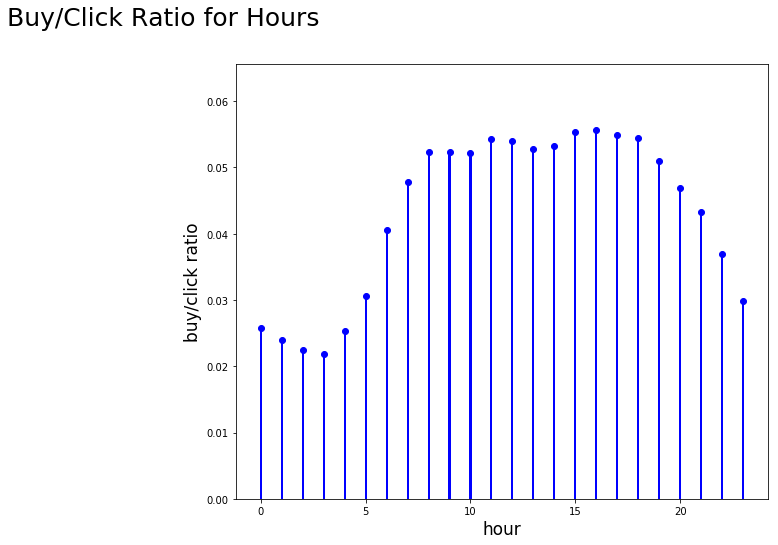

In [13]:
fig = plt.figure(figsize=(21,8))
fig.suptitle('Buy/Click Ratio for Hours', fontsize=25)
ax1 = fig.add_subplot(122)
ax1.scatter(hour_info['hour'],hour_info['ratio'],color='b')
ax1.bar(hour_info['hour'],hour_info['ratio'],width=0.1,color='b')
ax1.set_xlabel('hour', fontsize=17)
ax1.set_ylabel('buy/click ratio', fontsize=17)
plt.show()

In [14]:
# Buy ratio averaged for weekday
weekday_info=union.groupby(['weekday','status'])['session_id'].nunique().reset_index(name='count')
weekday_click=weekday_info[weekday_info['status']==0]
weekday_buy=weekday_info[weekday_info['status']==1]
weekday_info=pd.merge(weekday_click,weekday_buy,on='weekday')
weekday_info['ratio']=weekday_info.count_y/weekday_info.count_x

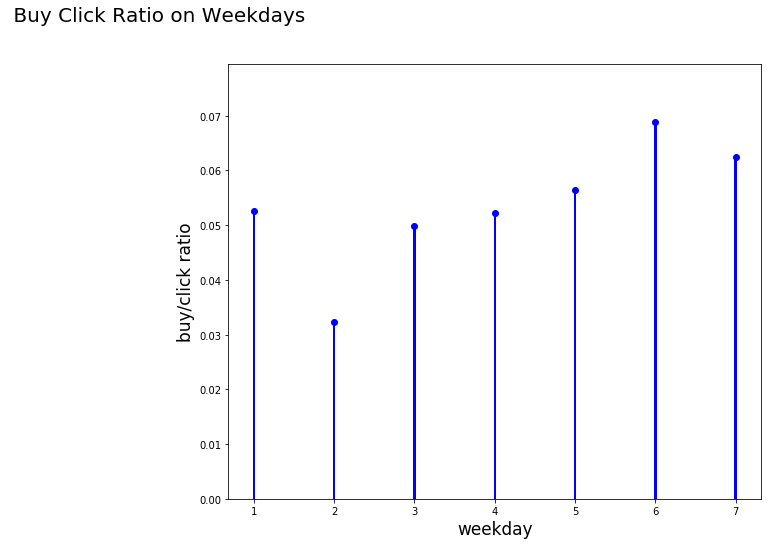

In [15]:
fig = plt.figure(figsize=(21,8))
fig.suptitle(' Buy Click Ratio on Weekdays', fontsize=20)

ax1 = fig.add_subplot(122)
ax1.scatter(weekday_info['weekday'],weekday_info['ratio'],color='b')
ax1.bar(weekday_info['weekday'],weekday_info['ratio'],width=0.03,color='b')
ax1.set_xlabel('weekday', fontsize=17)
ax1.set_ylabel('buy/click ratio', fontsize=17)
plt.show()

In [16]:
session_st=union[['session_id','status']]
session_status=session_st.groupby('session_id')['status'].max().reset_index(name='status')
session_length=union.groupby('session_id')['status'].count().reset_index(name='length')
session_length=pd.merge(session_status,session_length,on='session_id')

In [17]:
len_buys=session_length.groupby('length')['status'].sum().reset_index(name='buys')
len_num=session_length.groupby('length')['status'].count().reset_index(name='len_num')
len_aggr=pd.merge(len_buys,len_num,on='length')
len_aggr['ratio']=len_aggr.buys/len_aggr.len_num

In [18]:
len_aggr.head()

,length,buys,len_num,ratio
0,1,0,1237348,0.000000
1,2,20737,3468867,0.005978
2,3,80754,1620335,0.049838
3,4,71046,949366,0.074835
4,5,49557,548244,0.090392


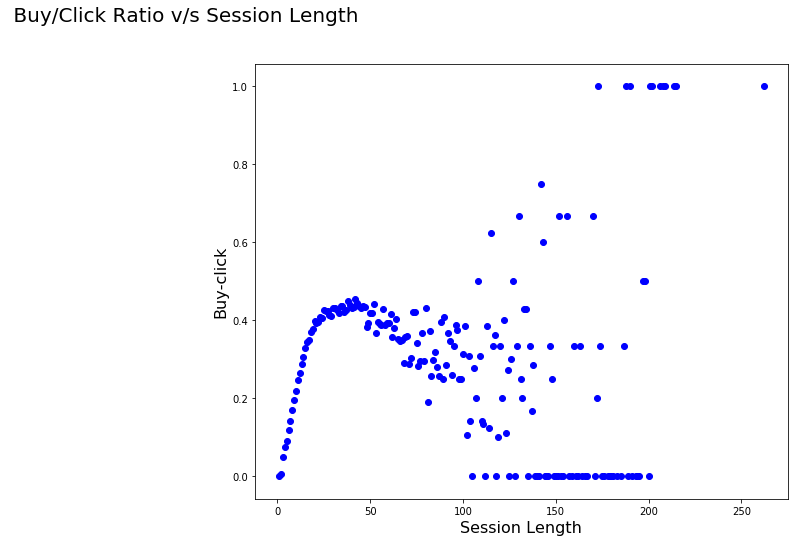

<Figure size 576x288 with 0 Axes>

In [19]:
fig = plt.figure(figsize=(21,8))
fig.suptitle(' Buy/Click Ratio v/s Session Length', fontsize=20)
ax1 = fig.add_subplot(122)
fig = plt.figure(figsize=(8,4))
ax1.scatter(len_aggr.length,len_aggr.ratio,color='b')
ax1.set_ylabel('Buy-click',fontsize=16)
ax1.set_xlabel('Session Length',fontsize=16)
#ax1.set_xscale('log')
plt.show()

In [20]:
dwell_max=union.groupby('session_id')['ts'].max().reset_index(name='max')
dwell_min=union.groupby('session_id')['ts'].min().reset_index(name='min')
session_dwell=pd.merge(dwell_max,dwell_min,on='session_id')
session_dwell['dwell']=(session_dwell['max']-session_dwell['min']).astype('timedelta64[m]')
session_dwell=pd.merge(session_dwell,session_status,on='session_id')
session_dwell.head()

,session_id,max,min,dwell,status
0,1,2014-04-07 10:57:00.306,2014-04-07 10:51:09.277,5.0,0
1,2,2014-04-07 14:02:36.889,2014-04-07 13:56:37.614,5.0,0
2,3,2014-04-02 13:30:12.318,2014-04-02 13:17:46.940,12.0,0
3,4,2014-04-07 12:26:25.416,2014-04-07 12:09:10.948,17.0,0
4,6,2014-04-06 17:02:26.976,2014-04-06 16:58:20.848,4.0,0


In [21]:
dwell_buys=session_dwell.groupby('dwell')['status'].sum().reset_index(name='buys')
dwell_num=session_dwell.groupby('dwell')['status'].count().reset_index(name='dwell_num')
dwell_aggr=pd.merge(dwell_buys,dwell_num,on='dwell')
dwell_aggr['ratio']=dwell_aggr.buys/dwell_aggr.dwell_num

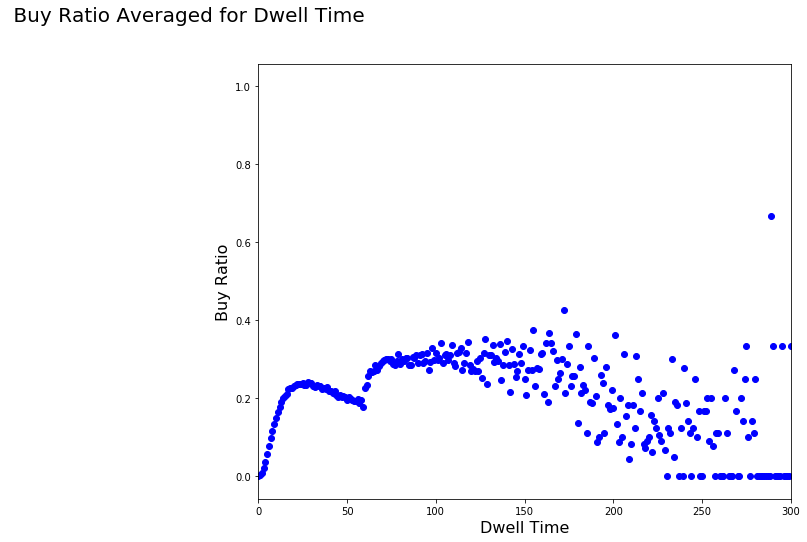

<Figure size 576x288 with 0 Axes>

In [22]:
fig = plt.figure(figsize=(21,8))
fig.suptitle(' Buy Ratio Averaged for Dwell Time', fontsize=20)
ax1 = fig.add_subplot(122)
fig = plt.figure(figsize=(8,4))
ax1.scatter(dwell_aggr.dwell,dwell_aggr.ratio,color='b')
ax1.set_ylabel('Buy Ratio',fontsize=16)
ax1.set_xlabel('Dwell Time',fontsize=16)
ax1.set_xlim(0,300)
plt.show()